<p style="color: #006bb3; font-size: 16px; font-style: italic; text-align: justify;">
    <p2 style="font-size: 32px;">CANCELACIÓN HOTELERA</p2></br>
    <p3 style="font-size: 24px;">Desarrollo de un modelo Machine Learning para la clasificación de reservas de alojamiento según su probabilidad de cancelación.</p3></br></br>
    <p4 style="color: black; font-size: 18px;">Proyecto desarrollado por Antonio García Valverde</p4>
</p>

---

<p align="center";">
  <img src="./src/img/novacancylite.png" alt="imagen" style=width: 100%;">
</p>

</br></br>
### Indice

1. [Planteamiento inicial](#1-Planteamiento-inicial)
    - [Problema de negocio](#11-Problema-de-negocio) 
    - [Problema técnico](#12-Problema-tecnico) 
2. [Revisión de datos proporcionados](#2-Revision-de-datos-proporcionados)  
3. [Análisis exploratorio (EDA)](#3-Analisis-exploratorio-(EDA)) 
    - [Carga de datos](#31-Carga-de-datos)
    - [Descripción de las variables](#32-Descripcion-de-las-variables)
    - [Visualización de variables](#33-Visualizacion-de-variables)
        - [Variable_target](#331-Variable-target)
        - [Resto de features](#332-Resto-de-features)
        - [Primeras conclusiones](#332-Primeras-conclusiones)
    - [Visualización detallada y transformaciones](#33-Visualizacion-detallada-y-transformaciones)
4. [Limpieza y transformacion](#4-limpieza-inicial-y-transformacion-de-los-datos)  

---


## 1 **Planteamiento inicial**
### 1.1 **Problema de negocio**
Una cadena hotelera solicita el desarrollo de un modelo clasificador de las reservas efectuadas en sus alojamientos capaz de anticiparse a una probable cancelación de la reserva.
Los motivos por los que consideran relevante este desarrollo son los siguientes:
* **Anticipación a la pérdida de negocio.**
Una reserva confirmada supone la asignación de un espacio de negocio con las condiciones pactadas.  
En caso de cancelación de esta reserva, la empresa puede contratar de nuevo el espacio, pero la dificultad para encontrar una nueva reserva puede conducir a pérdida total o parcial de negocio para ese espacio.  

* **Políticas de cancelación.**  
Con una buena aproximación a las reservas con alta probabilidad de cancelación, se pueden ajustar las políticas y períodos de cancelación que mantiene la empresa.
* **Elaboración de otros informes.**  
Otros análisis derivados de la clasificación pueden concluir en una mejora respecto a los períodos y clientes objetivos para futuras promociones.  


### 1.2 **Problema tecnico**
Para dar respuesta al problema de negocio planteado se propone el desarrollo de un modelo que reconozca las características de las reservas canceladas, puesto que se cuenta con unos datos previos recopilados por el negocio entre los años 2015 y 2018 con una variable que indica la confirmación o cancelación de la reserva, y que aplique ese reconocimiento para determinar la conclusión más probable de las futuras reservas.  
Se trata por tanto de un **problema supervisado de clasificación**, y se aplicarán los modelos correspondientes a ese punto de partida.

[Indice](#indice)

---

## 2 **Revision de datos proporcionados**
En el período 2015-2018 la empresa llevó a cabo una recopilación de datos para aplicar a estudios posteriores, conformando dos conjuntos de registros, denominados **Hotel_Bookings** y **Hotel_Reservations**.  
Partiendo de esas dos fuentes diferentes, con criterios equivalentes pero no iguales respecto a la nomenclatura y el número de variables, el primer paso en el desarrollo será inspeccionar ambos dataset para seleccionar las columnas de trabajo y unificar la nomenclatura para posteriormente unir ambos conjuntos en un único dataset de trabajo.   

Tras una primera exploración se puede observar, como ya nos había anticipado negocio, que los dataset tienen un número dispar de columnas, aunque el dataset con más columnas cuenta entre ellas con el equivalente de las columnas contenidas en el dataset con menos variables.  
La otra cuestión es su nomenclatura, que varía ligeramente entre las columnas coincidentes.  
Se procede a renombrar las columnas, eliminar las columnas no coincidentes, simplificar de nuevo la nomenclatura y unir los dataset.  

En una segunda revisión, se procede con la limpieza de los datos con los siguientes pasos:
* Eliminación de los registros con valores nulos de la columna *'children'*.
* Eliminación de los registros con valor *Undefined* en la variable *'meal_plan'*.
* Suma total del número de reservas del cliente.
* Se uniformizan los valores de las columnas coincidentes.
* Creación de una columna de fecha de reserva y eliminación de las columnas de fechas anteriores.
* Eliminación de columnas *'room_type'* y *'ms_type'*, por falta de protocolo en la toma de datos. 
* Reordenamiento de columnas y reindex a los registros. 

Se crean finalmente dos dataset de trabajo, uno sin registros duplicados, llamado *'Data_Reservas'*, y otro manteniendo los registros duplicados, llamado ***'Data_Reservas_full'***.
En pasos del proyecto posteriores se decidirá trabajar con el dataset completo, con registros duplicados, porque esos valores repetidos se han producido al eliminar los campos que identificaban de forma única a cada registro (nombre de cliente, identificador de reserva), pero se trataba originalmente de registros únicos con características repetidas, que pueden ayudar en la precisión del modelo como se ha comprobado posteriormente.  

El proceso de limpieza y montaje del dataset resultante puede seguirse en el **[notebook](./src/notebooks/1_notebook_preparacion_dataset.ipynb)** correspondiente a la preparación del dataset.  

[Indice](#indice)

---

## 3 **Analisis exploratorio (EDA)**

### 3.1 **Carga de datos y separación Train/Test**

In [ ]:
# Carga de las librerías necesarias en el proyecto
import os, sys
sys.path.append(os.path.abspath("../"))
import numpy as np
import optuna
import pandas as pd
import pickle

from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

#from src.utils.bootcampviztools import *
from src.utils.toolbox import *

In [13]:
# Se carga el dataset de trabajo
df = pd.read_csv("./src/data/Datos_Reservas_full.csv")
# Se separan los conjuntos de datos de train y test
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)
# Se identifica el target
target = "canceled"
# Se visualiza la información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153355 entries, 0 to 153354
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   daily_price     153355 non-null  float64
 1   lead_time       153355 non-null  int64  
 2   adults          153355 non-null  int64  
 3   children        153355 non-null  int64  
 4   repeated_guest  153355 non-null  int64  
 5   total_book      153355 non-null  int64  
 6   pre_cancel      153355 non-null  int64  
 7   pre_not_cancel  153355 non-null  int64  
 8   arr_date        153355 non-null  object 
 9   arr_week        153355 non-null  int64  
 10  week_nights     153355 non-null  int64  
 11  weekend_nights  153355 non-null  int64  
 12  meal_plan       153355 non-null  object 
 13  parking         153355 non-null  int64  
 14  special_req     153355 non-null  int64  
 15  canceled        153355 non-null  int64  
dtypes: float64(1), int64(13), object(2)
memory usage: 18.7+ 

### 3.2 **Descripcion de las variables**
<div style="background-color: AliceBlue;">

| Variable | Tipo | Descripción |
|:---------|:----:|:------------|
| daily_price | float64 | Precio diario medio de la reserva efectuada, en euros. |
| lead_time | int64 | Días transcurridos entre la fecha de reserva y el día previsto de llegada. | 
| adults | int64 | Número de huéspedes adultos de la reserva. |
| children | int64 | Número de huéspedes menores de edad en la reserva. | 
| repeated_guest | int64 |Variable que indica si el huésped ha sido cliente anteriormente (0 = No, 1 = Sí). | 
| total_book | int64 | Número total de reservas previas del cliente, si las hubiera. | 
| pre_cancel | int64 | Número total de cancelaciones previas del cliente. | 
| pre_not_cancel | int64 | Número total de reservas confirmadas previas del cliente. | 
| arr_date | datetime64 | Fecha de comienzo de la reserva. |
| arr_week | int64 | Semana de comienzo de la reserva. |
| week_nights | int64 | Número total de noches entre semana (lunes-viernes) que contiene la reserva. |
| weekend_nights | int64 | Número total de noches de fin de semana (sábado-domingo) que contiene la reserva.|
| meal_plan | object | Variable que especifica el tipo de menú enlazado a la reserva (SC = Apartamento, RO = Solo alojamiento, BB = Alojamiento y desayuno, HB = Media pensión, FB = Pensión completa). |
| parking | int64 | Número de plazas de aparcamiento vinculadas a la reserva. |
| special_req | int64 | Número total de peticiones especiales enviadas con la reserva. |
| canceled | int64 | Variable binaria que indica si se trata de una reserva confirmada (0) o cancelada (1). |

</div>

### 3.3 **Visualizacion de variables**

### 3.3.1 Variable target

In [15]:
# Se imprime la distribución de frecuencia relativa de la variable 'target' (0 = Confirmada, 1 = Cancelada)
pinta_distribucion_categoricas(train_set, [target], relativa = True)

NameError: name 'plt' is not defined

### 3.3.2 Resto de features

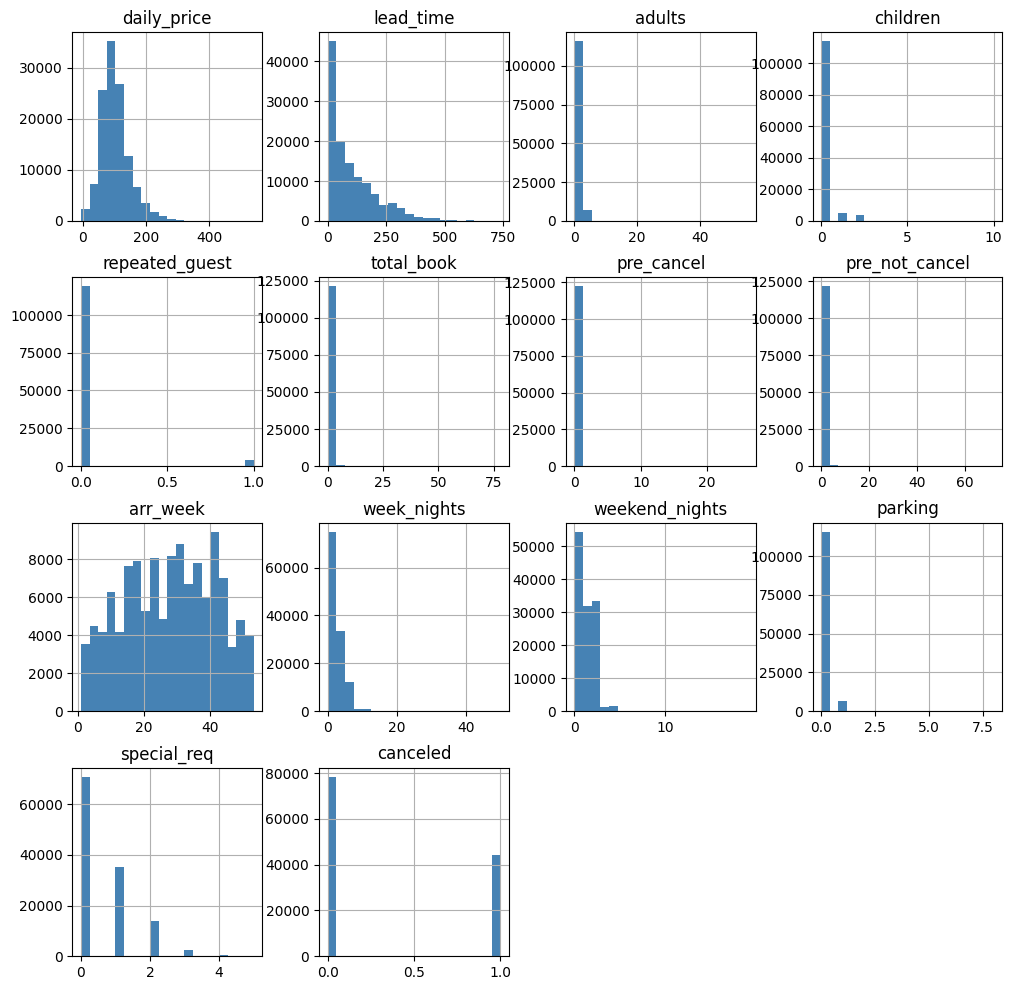

In [12]:
# Se revisa visualmente la distribución de todas las variables
train_set.hist(bins = 20, color = "steelblue", figsize = (12,12));

### 3.3.3 Primeras conclusiones
Mediante una observación superficial del dataset de trabajo al que se aplicarán los diferentes modelos de predicción se ha llegado a las siguientes conclusiones iniciales:
* La variable target está algo descompensada y habrá que decidir si se aplica alguna medida correctora para mitigar la diferencia de datos (oversampling, undersampling).
* Todas las variables son numéricas, lo que facilitará la aplicación de diferentes modelos, aunque aun deben distinguirse las variables numéricas naturales y las variables categóricas que cuentan con números como etiquetas.
* En alguna variables categóricas no binarias o numéricas discretas se aplicarán transformaciones para convertir en binarias según la distribución de valores que tengan.

### 3.4 **Visualizacion detallada y transformaciones**
Todas las variables han sido visualizas de forma individual y combinadas de dos en dos, siempre en relación a la variable target.  
En la mayoría de los casos no se encuentran diferencias relevantes entre los KDE de las reservas confirmadas y canceladas, salvo en alguna excepción que se adjunta a este notebook como complemento visual.  
  
Todo el proceso de análisis exploratorio de datos se puede comprobar **[aquí](./src/notebooks/2_notebook_EDA.ipynb)**. 

In [1]:
# Distribución de la variable en relación al 'target' (0 = No cancelada, 1 = Cancelada), sin tener en cuenta los outliers para aproximar la vista
plot_grouped_histograms(train_set[train_set.daily_price <= 2000],"canceled", "daily_price",2);

NameError: name 'plot_grouped_histograms' is not defined

¿Por qué hay registros con valor cero en el importe medio diario?  
¿Pueden ser promociones?



In [27]:
# #---------------------------- CAMBIO 1-----------------------------------------
# # ASIGNACIÓN DE MEDIANA A POMOCIONES Y DEVOLUCIONES
# # ASIGNACIÓN DE MEDIANA A VALORES NULL
# # TRANSFORMACIÓN LOGÍSTICA A LA COLUMNA 'daily_price'
# df.loc[df["daily_price"] <= 0, "daily_price"] = 95.2
# df.loc[df["daily_price"].isnull(), "daily_price"] = 95.2
# df["daily_price"] = np.log10(df["daily_price"])
# #---------------------------- CAMBIO 2-----------------------------------------
# # ASIGNACIÓN DE MEDIANA A VALORES INCONSISTENTES Y TRANSFORMACIÓN LOGÍSTICA A LA COLUMNA 'lead_time'
# df.loc[df["lead_time"] <= 0, "lead_time"] = 66
# df.loc[df["lead_time"].isnull(), "lead_time"] = 66
# df["lead_time"] = np.log10(df["lead_time"])
# #---------------------------- CAMBIO 3-----------------------------------------
# # ASIGNACIÓN DE MEDIANA EN 'adults' DE REGISTROS CON VALOR 0 COINCIDENTES EN LAS COLUMNAS 'adults' Y 'children'
# # ASIGNACIÓN DE MEDIANA A VALORES NULL
# df.loc[df["adults"].isnull(), "adults"] = 2
# df.loc[df["children"].isnull(), "children"] = 0
# df.loc[(df["adults"] < 0), "adults"] = 0
# df.loc[(df["children"] < 0), "children"] = 0
# df.loc[((df["adults"] <= 0)&(df["children"] <= 0)), "adults"] = 2
# #---------------------------- CAMBIO 4-----------------------------------------
# # TRANSFORMACIÓN DE 'children' A CATEGÓRICA BINARIA
# df.loc[df["children"] > 0, "children"] = 1
# #---------------------------- CAMBIO 5-----------------------------------------
# # TRANSFORMACIÓN DE 'total_book' A CATEGÓRICA BINARIA
# # ASIGNACIÓN DE MEDIANA A VALORES NULL
# df.loc[df["total_book"].isnull(), "total_book"] = 0
# df.loc[df["total_book"] < 0, "total_book"] = 0
# df.loc[df["total_book"] > 0, "total_book"] = 1
# #---------------------------- CAMBIO 6-----------------------------------------
# # TRANSFORMACIÓN DE 'pre_cancel' Y 'pre_not_cancel' A CATEGÓRICA BINARIA
# # ASIGNACIÓN DE MEDIANA A VALORES NULL
# df.loc[df["pre_cancel"].isnull(), "pre_cancel"] = 0
# df.loc[df["pre_not_cancel"].isnull(), "pre_not_cancel"] = 0
# df.loc[df["pre_cancel"] < 0, "pre_cancel"] = 0
# df.loc[df["pre_not_cancel"] < 0, "pre_not_cancel"] = 0
# df.loc[df["pre_cancel"] > 0, "pre_cancel"] = 1
# df.loc[df["pre_not_cancel"] > 0, "pre_not_cancel"] = 1
# #---------------------------- CAMBIO 7-----------------------------------------
# # ASIGNACIÓN DE MEDIANA EN VALORES INCONSISTENTES COINCIDENTES EN LAS COLUMNAS 'week_nights' y 'weekend_nights'
# # TRANSFORMACIÓN DE ETIQUETAS PARA UNIFICAR LOS VALORES POR ENCIMA DE 5 EN 'week_nights' Y POR ENCIMA DE 2 EN 'weekend_nights'
# # ASIGNACIÓN DE MEDIANA A VALORES NULL
# df.loc[df["week_nights"].isnull(), "week_nights"] = 2
# df.loc[df["weekend_nights"].isnull(), "weekend_nights"] = 1
# df.loc[df["week_nights"] < 0, "week_nights"] = 0
# df.loc[df["weekend_nights"] < 0, "weekend_nights"] = 0
# df.loc[((df["week_nights"] == 0)&(df["weekend_nights"] == 0)), "week_nights"] = 2    
# df.loc[df["week_nights"] > 5, "week_nights"] = 6
# df.loc[df["weekend_nights"] > 2, "weekend_nights"] = 3
# #---------------------------- CAMBIO 8-----------------------------------------
# # TRANSFORMACIÓN DE 'meal_plan' A VARIABLE NUMÉRICA CON ORDINAL ENCODER
# # ASIGNACIÓN DE MODA A VALORES NULL
# list_meal = ["SC","RO","BB","HB","FB"]
# df.loc[df["meal_plan"].isnull(), "meal_plan"] = "BB"
# df.loc[~df["meal_plan"].isin(list_meal), "meal_plan"] = "BB"   
# encoder = OrdinalEncoder(categories=[["SC","RO","BB","HB","FB"]])    
# df[["meal_plan"]] = encoder.fit_transform(df[["meal_plan"]])
# #---------------------------- CAMBIO 9-----------------------------------------
# # TRANSFORMACIÓN DE 'parking' A VARIABLE BINARIA
# # ASIGNACIÓN DE MEDIANA A VALORES NULL
# df.loc[df["parking"].isnull(), "parking"] = 0
# df.loc[df["parking"] < 0, "parking"] = 0
# df.loc[df["parking"] > 0, "parking"] = 1

# #---------------------------- CAMBIO 10-----------------------------------------
# # ELIMINACIÓN DE 'arr_date'
# df.drop(columns = ["arr_date"], inplace = True)

In [1]:
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from src.utils.toolbox import *

In [2]:
# Se lee el dataset de trabajo
df = pd.read_csv("./src/data/Datos_Reservas_full.csv")

# Se extrae una muestra aleatoria de mil registros y se guarda el archivo, con y sin target
df_muestra = df.sample(1000, random_state = 42)
df_muestra.to_csv("./src/data_sample/muestra_reservas.csv", index = False) 
df_muestra_x = df_muestra.drop(columns = ["canceled"])
df_muestra_x.to_csv("./src/data_sample/muestra_reservas_sin_target.csv", index = False) 

# Se eliminan esos registros del dataset original
df = df[~df.isin(df_muestra).all(axis=1)]

In [3]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)
target = "canceled"

In [4]:
# Se forman los subconjuntos X,y
X_train = train_set.copy()
X_train.drop(columns = [target], inplace = True)
y_train = train_set[target].copy()

X_test = test_set.copy()
X_test.drop(columns = [target], inplace = True)
y_test = test_set[target].copy()

In [5]:
# Procesado a través de pipeline
processor = FunctionTransformer(total_transform)

# Se añade el modelo con los ajustes establecidos previamente
pipeline_RFC = Pipeline(
    [("Procesado", processor),
     ("Classifier", RandomForestClassifier(criterion = "log_loss", n_estimators = 290, max_depth = 30, min_samples_split = 2, min_samples_leaf = 1, max_features = None, class_weight = "balanced", random_state = 42))])

pipeline_RFC

Pipeline(steps=[('Procesado',
                 FunctionTransformer(func=<function total_transform at 0x0000024CF421B9C0>)),
                ('Classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='log_loss', max_depth=30,
                                        max_features=None, n_estimators=290,
                                        random_state=42))])

In [6]:
pipeline_RFC.fit(X_train, y_train)

Pipeline(steps=[('Procesado',
                 FunctionTransformer(func=<function total_transform at 0x0000024CF421B9C0>)),
                ('Classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='log_loss', max_depth=30,
                                        max_features=None, n_estimators=290,
                                        random_state=42))])

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     19474
           1       0.81      0.78      0.80     10997

    accuracy                           0.86     30471
   macro avg       0.85      0.84      0.84     30471
weighted avg       0.86      0.86      0.86     30471



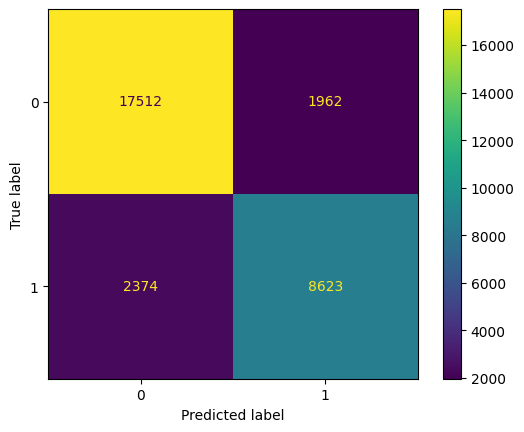

In [7]:
# Evaluación
y_pred_pipeline = pipeline_RFC.predict(X_test)
print(classification_report(y_test, y_pred_pipeline))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pipeline);

In [8]:
# Se guarda el modelo con pickle:
with open("./src/models/model_pl_RF.pkl", "wb") as archivo:
    pickle.dump(pipeline_RFC, archivo)